In [55]:
import math
import json
import os
import glob
import numpy as np
import argparse
import plotly.graph_objects as go
import functools
from plotly.subplots import make_subplots
from timeit import default_timer as timer
import pickle
from statistics import mean

In [56]:
with open("final_results.dat","rb") as f:
    scenarios = pickle.load(f)

In [57]:
# PARAMETERS
samplingRate = 5 # in seconds
h_NMAC = 4 # in m
t_conf = 15

In [58]:
def calcLossOfHorizontalSafetyDistance(ownship, traffic, h_THRESHOLD):
        h = []
        lowc = []
        
        resample_ownship = resample(ownship['time'],step, tolerance, duration)
        resample_traffic = resample(traffic['time'], step, tolerance, duration)
        
        for i, tposNED in enumerate(traffic['positionNED']):
            posNED = ownship["positionNED"][i]
            o_alt = posNED[2]
            t_alt = tposNED[2]
            
            dist = np.sqrt((posNED[0] - tposNED[0])**2 + (posNED[1] - tposNED[1])**2) 
            
            horiz_violation = (dist < h_THRESHOLD)
            
            h.append(dist)

            if horiz_violation:
                lowc.append(1)
            else:
                lowc.append(0)
        
        lowcNP = np.array(lowc)
        hNP = np.array(h)
        
        return (lowcNP, hNP)
    
def findRangeOfOnes(zeroOneNPArray):
    idx = np.where(zeroOneNPArray==1)[0]
    
    if len(idx) > 0:
        return [idx[0], idx[-1]]
    else:
        return [-1, -1]

def regainSafetyDistance(zeroOneNPArray):
    return np.any(np.diff(zeroOneNPArray) == -1)
    #zeroOneNPArray_idx = findRangeOfOnes(zeroOneNPArray)
    #return -1 < zeroOneNPArray_idx[1] and zeroOneNPArray_idx[0] < len(zeroOneNPArray)-1

def calculate_time(zeroOneNPArray):
    return sum(zeroOneNPArray) * samplingRate

def calcSeverity(h_dist, h_THRESHOLD):
    h_severity = (h_THRESHOLD - h_dist) / h_THRESHOLD
    h_severity[h_severity < 0] = 0
    return h_severity



In [3]:
ex = {1:(0,2),2:(3,4)}

b = [d[0] for d in ex.values()]
max(b)

3

In [59]:
'''
    duhet kjo
'''

class Scenario:
    def __init__(self,name,logs):
        self.name = name
        self.logs = logs
        
        
        #self.params = self.logs[0]['parameters']
    
    @staticmethod
    def resample(arr, step, tolerance,duration):
        '''
             resample per t'marre cdo x sekonda 
        '''
        res = {}

        for curr_time in range(0,duration,step):
            candidates = []
            diffs = []
            #candidates_idx = []
            #print(curr_time)
            ub = 0
            for i, t in enumerate(arr):
                diff = abs(float(t - curr_time))
                if diff <= tolerance:
                    candidates.append(i)
                    diffs.append(diff)
            if len(diffs) == 1:
                winner = candidates[0]
            elif len(diffs) > 1:
                val, idx = min((val, idx) for (idx, val) in enumerate(diffs)) #fut ate qe ka diferencen me t vogel me kohen e ownship
                winner = candidates[idx]
            else:
                winner = -1
                #print("Nuk gjetem gje per kohen "+str(curr_time))
            res[curr_time] = winner


        return res
    

    @functools.cached_property
    #@property
    def params(self):
        
        
        with open(self.logs[0],'r') as f:
            data = json.load(f)
        return data['parameters']
    
    @functools.cached_property
    def delay(self):
        d = []
        for log in self.logs:
            with open(log,'r') as f:
                data = json.load(f)
            ownship = data['state']
            delay = ownship['update_delay']
            if delay == 0.:
                traffic = data['traffic']['tf1']
                delay = traffic['time'][0] - ownship['time'][0]
            d.append(delay)
        
        return d
    @functools.cached_property
    def max_sev_per_run(self):
        dist_lowc_sev = self.dist_lowc_sev
        
        max_lowc_sev = []
        for run in dist_lowc_sev:
            sev = [d[2] for d in run.values()]
            max_lowc_sev.append(max(sev))
        return max_lowc_sev
    @functools.cached_property
    def lowc_duration(self):
        dist_lowc_sev = self.dist_lowc_sev
        
        max_lowc_sev = []
        for run in dist_lowc_sev:
            sev = [d[2] for d in run.values()]
            count = 0 
            for s in sev:
                if s > 0:
                    count+=1
            max_lowc_sev.append(count)
        return count
        
    @functools.cached_property
    #@property
    def dist_lowc_sev(self):
        h_thresh = self.get_thresh()
        dist_lowc_sev = []
        r = 0
        for log in self.logs:
            curr_dwc = {}
            with open(log,'r') as f:
                data = json.load(f)
            
            traffic = data['traffic']['tf1']
            ownship = data['state']
            
            duration = 300 #sekonda
            step = 1 # cdo 1 sekonda
            tolerance = 0.5 # merr me te aferten ne dritare +- 0.5 sekonda
        
            resampled_ownship = Scenario.resample(ownship['time'],step,tolerance,duration)
            resampled_traffic = Scenario.resample(traffic['time'],step,tolerance,duration)
            
            
            for i in range(0, duration, step):
                if resampled_ownship[i] != -1 and resampled_traffic[i] != -1:
                    
                    posNED = ownship['positionNED'][resampled_ownship[i]]
                    tposNED = traffic['positionNED'][resampled_traffic[i]]
                    
                    dist = np.sqrt((posNED[0] - tposNED[0])**2 + (posNED[1] - tposNED[1])**2) 
            
                    horiz_violation = (dist < h_thresh)
                    
                    #h.append(dist)

                    if horiz_violation:
                        lowc = 1
                    else:
                        lowc = 0
                        
                    sev = (h_thresh - dist) / h_thresh
                    if sev < 0:
                        sev = 0
                    curr_dwc[i] = (dist, lowc,sev)
            dist_lowc_sev.append(curr_dwc)
            r +=1
            
            
        
        return dist_lowc_sev
    
    @functools.cached_property
    #@property
    def severity(self):
        severity = []
        dist_lowc = self.dist_lowc
        h_thresh = self.get_thresh()
        for run in dist_lowc:
            print(run)
            run_sev = {}
            for time, d_lwc in run.items():
                dist = d_lwc[0]
                sev = (h_thresh - dist) / h_thresh
                if sev < 0:
                    sev = 0
                run_sev[time] = sev
            
            severity.append(run_sev)
        return severity
        
    @functools.cached_property
    #@property
    def mean_severity(self):
        dist_lowc_sev = self.dist_lowc_sev
        
        #print(dist_lowc_sev)
        mean_severity = {}
        for i in range(0,300, 1):
            values = []
            for run in dist_lowc_sev:
                if i in run.keys():
                    values.append(run[i][2])
                
            if len(values) > 0:
                mean_severity[i] = (sum(values) / len(values), len(values))
        
        
        return mean_severity
    
    @functools.cached_property
    def mean_dist(self):
        dist_lowc_sev = self.dist_lowc_sev
        mean_dist = {}
        
        for i in range(0,300, 1):
            values = []
            for run in dist_lowc_sev:
                if i in run.keys():
                    values.append(run[i][0])
            if len(values) > 0:
                
                mean_dist[i] = (sum(values) / len(values), len(values))   
            #mean_dist[i] = (sum(values) / len(values), len(values))
            
        return mean_dist
    
        
        
    
    @functools.cached_property
    def max_mean_severity(self):
        mean_severity = self.mean_severity
        sev = [d[0] for d in mean_severity.values()]
        return max(sev)
    
    
    def get_thresh(self):
        return self.params['DET_1_WCV_DTHR']* 0.3048
    @functools.cached_property
    def t_lookahead(self):
        return self.params['LOOKAHEAD_TIME']
    @functools.cached_property
    def t_alert(self):
        return self.params['AL_1_ALERT_T']
    @functools.cached_property
    def turn_rate(self):
        return self.params['TURN_RATE']
    
    def get_param(self, key):
        if key in self.params.keys():
            return self.params[key]
        else:
            return 'Nuk ke gje ktu'
    
    
    
    
    

[2, 8, 0, 0, 2, 1, 9, 0, 3, 2, 6, 3, 0, 0, 0, 11, 8, 0, 2, 0, 0, 0, 7, 5, 3, 0, 0, 0, 4, 8, 0, 9, 0, 8, 0, 0, 0, 6, 0, 0, 0, 0, 6, 4, 0, 5, 0, 6, 0, 0, 10, 0, 0, 10, 3, 4, 0, 7, 0, 0, 0, 0, 0, 0, 5, 3, 8, 0, 0, 0, 8, 6, 6, 0, 5, 6, 0, 0, 11, 9, 0, 0, 4, 6, 6, 4, 8, 0, 5, 0, 7, 0, 8, 0, 0, 0, 0, 0, 8, 6, 8, 0, 0, 8, 6, 4, 0, 6, 0, 6, 9, 7, 0, 10, 0, 0, 8, 0, 4, 0, 0, 0, 8, 0, 11, 0, 0, 10, 6, 0, 2, 6, 0, 9, 0, 0, 0, 5, 4, 8, 3, 9, 0, 9, 0, 0, 0, 11, 0, 10, 7, 3, 0, 8, 2, 0, 8, 0, 0, 0, 4, 7, 0, 0, 0, 0, 2, 0, 8, 0, 0, 5, 0, 7, 3, 0, 6, 4, 5, 8, 0, 0, 5, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 11, 0, 6, 8, 0, 0, 0, 2, 8, 0, 2, 0, 3, 6, 0, 6, 0, 6, 0, 4, 5, 0, 0, 4, 9, 3, 0, 2, 0, 5, 0, 0, 0, 0, 0, 9, 5, 0, 2, 0, 4, 3, 0, 6, 10, 10, 1, 6, 8, 0, 0, 0, 4, 0, 19, 0, 7, 1, 0, 11, 9, 7, 10, 4, 9, 7, 0, 6, 10, 0, 5, 8, 6, 2, 3, 6, 3, 8, 0, 0, 9, 5, 0, 4, 6, 5, 7, 0, 4, 3, 9, 3, 0, 0, 6, 0, 8, 0, 0, 0, 9, 0, 0, 3, 6, 0, 3, 5, 0, 0, 0, 0, 0, 7, 4, 0, 9, 1, 0, 5, 4, 5, 9, 6, 0, 0, 0, 0, 7, 0, 7, 0, 0,

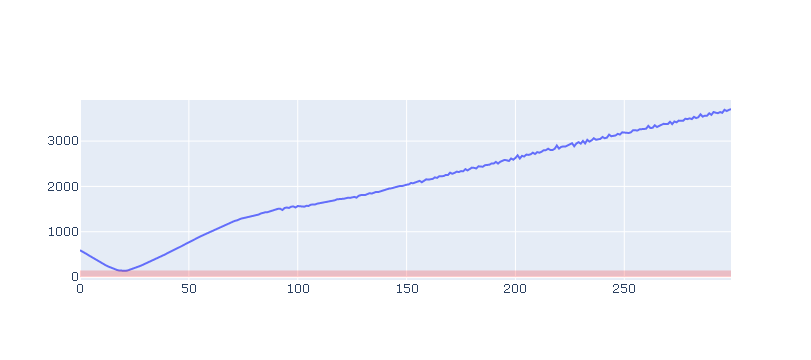

In [72]:
i = 0
for idx, scenario in enumerate(scenarios):
    if scenario.name == 'St7tr90h0v20vi10':
        i = idx
        break
scenario = scenarios[i]
thresh = scenario.get_thresh
dist = scenario.mean_dist
x = list(dist.keys())
y = [v[0] for v in dist.values()]
#lowc = scenario.dist_lowc_sev
#dlowc = scenario.mean_severity

time = scenario.lowc_duration
print(time)
fig = go.Figure()

fig.add_trace(go.Scatter(x=x, y=y,
                    mode='lines',
                 name='lines'))
fig.add_hrect(y0=0.0, y1=scenario.get_thresh(), line_width=0, fillcolor="red", opacity=0.2)
fig.show()


In [5]:
'''
    mnyr tjeter per me lexu kto fajle
'''
lowc_time = []
lowc_percentage = []
distances = []
nmac_time = []
nmac_percentage = []
thresh = []
lookahead = []
alert = []

severity = []
scenarios = []

for f in glob.glob("/home/uas/icarous/Python/pycarous/log/*"):
    scenarioname = f.split('/')[-1]
    seen = False
    logs = []
    for logfile in glob.glob(f+'/*'):
        #with open(logfile,'r') as f:
        #    data = json.load(f)
        #    logs.append(data)
        logs.append(logfile)
    scenarios.append(Scenario(scenarioname,logs))
    
        
    


In [7]:
for scenario in scenarios:
    if ".log" not in scenario.name and "det" not in scenario.name:
        print(scenario.name+"---------------------\n")
        d = scenario.delay
        p = scenario.params
        mms = scenario.max_mean_severity
        md = scenario.mean_dist
        dls = scenario.dist_lowc_sev
        k = scenario.max_sev_per_run
        d = scenario.lowc_duration
        ms = scenario.mean_severity
        
       # print(str(scenario.mean_dist))

St8tr20h90v10---------------------

St6tr45h90v15---------------------

St4tr45h90v10---------------------

St8tr30h90v20---------------------

St6tr20h90v20---------------------

St4tr45h180v10---------------------

St8tr20h180v10---------------------

St4tr90h180v10---------------------

St6tr45h180v10---------------------

St6tr45h90v20---------------------

St6tr30h90v10---------------------

St4tr30h180v10---------------------

St8tr15h90v20---------------------

St6tr60h180v10---------------------

St4tr90h90v10---------------------

St4tr45h90v15---------------------

St6tr60h90v10---------------------

St4tr90h90v15---------------------

St6tr90h90v15---------------------

St8tr45h90v10---------------------

St4tr30h90v15---------------------

St4tr60h90v15---------------------

St4tr60h90v10---------------------

St8tr60h90v20---------------------

St8tr60h180v10---------------------

St6tr60h90v20---------------------

St6tr30h90v15---------------------

St6tr30h90v20--------

In [8]:
pickle.dump(scenarios,open("new_results.dat", 'wb'))


104.85120335523841
145.0848046427136
79.85760255544321
104.85120335523841
85.0392027212544
145.0848046427136
79.85760255544321
70.104002243328
185.01360592043523
164.89680527669762
70.104002243328
74.98080239938561
95.0976030431232
74.98080239938561
74.98080239938561
64.92240207751681
54.86400175564801
60.04560192145921
164.89680527669762
64.92240207751681
95.0976030431232
114.90960367710721
145.0848046427136
124.968003998976
104.85120335523841
70.104002243328
145.0848046427136
135.0264043208448
114.90960367710721
164.89680527669762
74.98080239938561
79.85760255544321
70.104002243328
64.92240207751681
70.104002243328
64.92240207751681
64.92240207751681
145.0848046427136
54.86400175564801
60.04560192145921
124.968003998976
124.968003998976
164.89680527669762
54.86400175564801
74.98080239938561
85.0392027212544
124.968003998976
114.90960367710721
85.0392027212544
74.98080239938561
79.85760255544321
74.98080239938561
145.0848046427136
155.14320496458242
185.01360592043523
164.896805276697

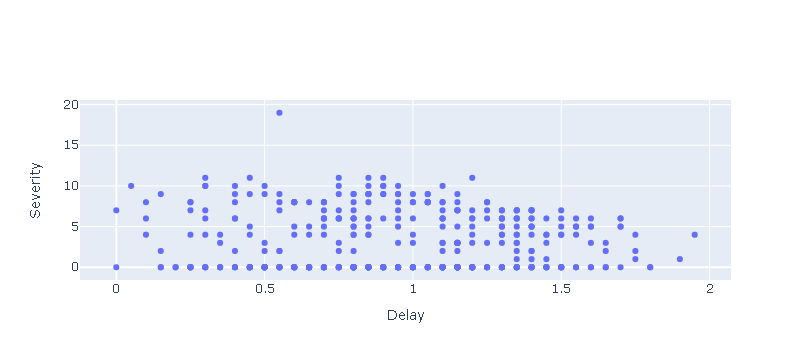

In [20]:
for scenario in scenarios:
    print(scenario.get_thresh())
    if scenario.name == 'St6tr90h0v20vi10':
        i = idx
        break
scenario = scenarios[i]

delay = scenario.delay
sev = scenario.lowc_duration

fig = go.Figure()

# Add traces
fig.add_trace(go.Scatter(x=delay, y=sev,
                    mode='markers'))
fig.update_xaxes(title='Delay')
fig.update_yaxes(title="Severity")
fig.show()

In [42]:
alert_times = [6.0, 7.0, 8.0]
t1 = []
t2 = []
t3 = []
for scenario in scenarios:
    if ".log" not in scenario.name and "det" not in scenario.name:
        if len(scenario.logs)>0:
            sev = [v[0] for k,v in scenario.mean_severity.items()]
            if scenario.t_alert == 5.0:
                t1.append(sev)
            elif scenario.t_alert == 6.0:
                t2.append(sev)
            else:
                t3.append(sev)
            

entered


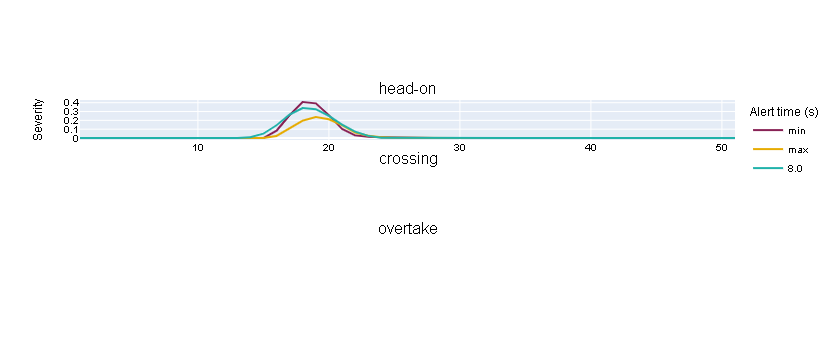

In [54]:
s1 = []
s2 = []
s3 = []
#fig = go.Figure()
fig = make_subplots(rows=3, cols=1,subplot_titles=("head-on","crossing", "overtake"))
for scenario in scenarios:
    if scenario.name == "St5tr90h0v20vi15":
        print('entered')
        sev = [v[0] for k,v in scenario.mean_severity.items()]
        s1 = sev
        fig.add_trace(go.Scatter(x=list(range(0,300)), y=s1,
                    mode='lines',
                    marker=dict(
                    color='rgb(136,34,85)', #set color equal to a variable
                     ),
                    name='min',showlegend=True),row=1, col=1)
        
    elif scenario.name == "St6tr90h0v20vi15":
        
        sev = [v[0] for k,v in scenario.mean_severity.items()]
        s2 = sev
        fig.add_trace(go.Scatter(x=list(range(0,300)), y=s2,
                    mode='lines',
                    marker=dict(
                    color='rgb(230,171,2)', #set color equal to a variable
                     ),
                    name='max',showlegend=True),row=1, col=1)
        
    elif scenario.name == "St7tr90h0v10vi15":
        sev = [v[0] for k,v in scenario.mean_severity.items()]
        s3 = sev
        fig.add_trace(go.Scatter(x=list(range(0,300)), y=s3,
                    mode='lines',
                                 marker=dict(
                    color='lightseagreen', #set color equal to a variable
                     ),
                    name='8.0',showlegend=True),row=1, col=1)
                    
   
    
fig.update_layout(
    #title="Plot Title",
    #xaxis_title="Time (s)",
    yaxis_title="Severity",
    legend_title="Alert time (s)",
    font=dict(
        family="Helvetica",
        size=10,
        color="Black"
    )
)
fig.update_xaxes(title_text="Time (s)", row=3, col=1)
fig.update_xaxes(range=list([1,51]))

fig.show()

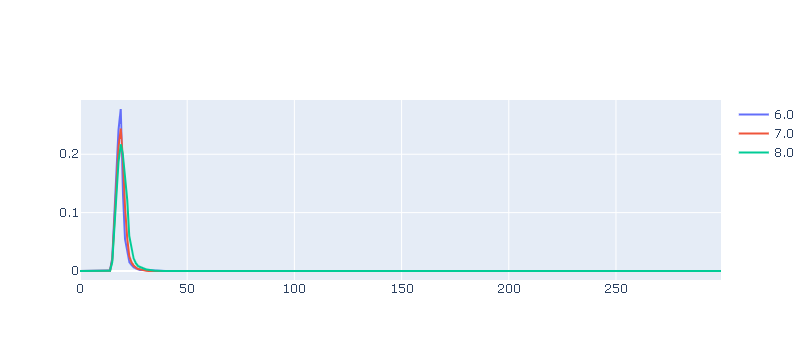

In [44]:
fig = go.Figure()
for idx,t in enumerate([t1,t2,t3]):
    v = np.array(t)
    v = np.median(v, axis=0)
    fig.add_trace(go.Scatter(x=list(range(0,300)), y=v,
                    mode='lines',
                    name=str(alert_times[idx]),showlegend=True))
fig.show()

In [31]:
for s in scenarios:
    if s.name == "St4tr90h180v10" :
        print ("found it")


found it


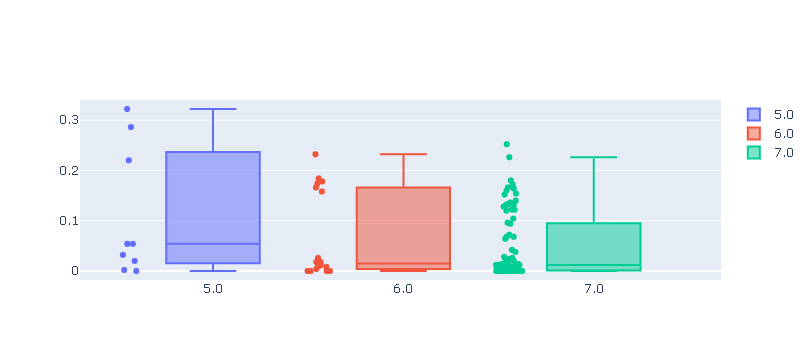

In [46]:
alert_times = [5.0,6.0,7.0]
n1 = []
n2 = []
n3 = []
fig = go.Figure()
for scenario in scenarios:
    if ".log" not in scenario.name and "det" not in scenario.name:
        if len(scenario.logs)>0:
            nmac = 0
            for dls in scenario.dist_lowc_sev:
                dist = [v[0] for k, v in dls.items()]
                dist = np.array(dist)
                if np.any(dist<=12):
                    nmac += 1
            nmac = nmac/500
            if scenario.t_alert == 5.0:
                n1.append(nmac)
            elif scenario.t_alert == 6.0:
                n2.append(nmac)
            else:
                n3.append(nmac)
for idx, n in enumerate([n1,n2,n3]):
    fig.add_trace(go.Box(
    y=n,
    name=str(alert_times[idx]),
    jitter=0.3,
    pointpos=-1.8,
    boxpoints='all', # represent all points
    ))
fig.show()

In [9]:
print(len(n3))

42


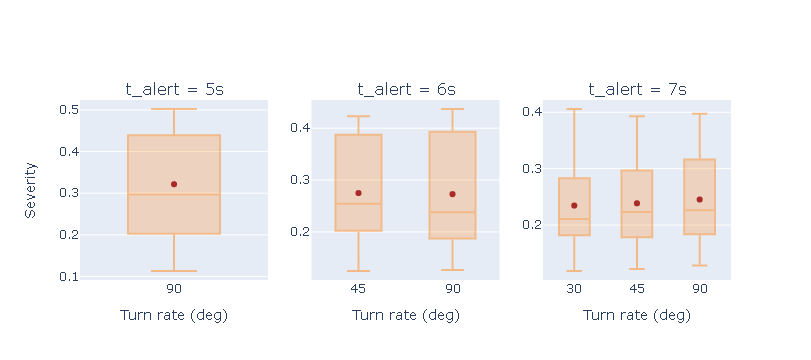

In [47]:
alert_times = [5.0, 6.0, 7.0]
fig = make_subplots(rows=1,cols=3, subplot_titles=("t_alert = 5s", "t_alert = 6s", "t_alert = 7s"))
c = 1
for alert in alert_times:
    
    res = {}
    for scenario in scenarios:
        if ".log" not in scenario.name and "det" not in scenario.name:
            if len(scenario.logs) > 0:
                if scenario.t_alert == alert:
                    
                    start = timer()
                    if scenario.turn_rate in res.keys():
                        res[scenario.turn_rate].append(scenario.max_mean_severity)
                    else:
                        res[scenario.turn_rate] = [scenario.max_mean_severity]
                    
                    end = timer()
                    
            else:

                print("SKENARI "+scenario.name+" SKA LOGJE")
        res_sorted =  {key: value for key, value in sorted(res.items())}
    for k,val in res_sorted.items():
        fig.add_trace(go.Box(
                            y=val,
                            name=str(k),
                            boxpoints='outliers', # represent all points,
                            pointpos = 0,
                            opacity = 0.5,
             
                            marker_color='#FF851B',
                            line_color='#FF851B',
                            showlegend=False
                        ),row=1, col=c)

        fig.add_trace(go.Scatter(x=[str(k)], y=[mean(val)],
            mode='markers',
            marker_color='rgba(152, 0, 0, .8)',showlegend=False),row=1,col=c)
#print(res)
#break
    c += 1
fig.update_xaxes(title_text="Turn rate (deg)", row=1, col=1)
fig.update_xaxes(title_text="Turn rate (deg)", row=1, col=2)
fig.update_xaxes(title_text="Turn rate (deg)", row=1, col=3)

fig.update_yaxes(title_text="Severity", row=1, col=1)



fig.show()

In [ ]:
lowc_time = []
lowc_percentage = []
distances = []
nmac_time = []
nmac_percentage = []

severity = []
scenarios = []

for f in glob.glob("simlog-St7*"):
    
    scenarioname = str(f.split('-')[1]).split('.')[0]
    scenarios.append(scenarioname)
    
    with open(f, 'r') as infile:
        data = json.load(infile)
    traffic = data['traffic']['tf1']
    ownship = data['state']
    h_THRESHOLD = data['parameters']['DET_1_WCV_DTHR']* 0.3048
    t_lookahead = data['parameters']['LOOKAHEAD_TIME']
    t_alert = data['parameters']['AL_1_ALERT_T']
    
    print(h_THRESHOLD)
    
    missionDuration = float(samplingRate * len(traffic))
    
    loTHRESHOLD, h_distTHRESHOLD = calcLossOfHorizontalSafetyDistance(ownship, traffic, h_THRESHOLD)
    distances.append(h_distTHRESHOLD)
    #print (loTHRESHOLD)
    s = calcSeverity(h_distTHRESHOLD, h_THRESHOLD)
    severity.append(s)
    
    #per te pare nese esht rifituar wc
    regained = regainSafetyDistance(loTHRESHOLD)
    #etj
    
    # calculate the time during which there is a loss of h_THRESHOLD
    durationLoTHRESHOLD = calculate_time(loTHRESHOLD)
    lowc_time.append(durationLoTHRESHOLD)
    print(durationLoTHRESHOLD)
    
    # calculate the percantage of time during which there is a loss of h_THRESHOLD with respect to the total mission time
    percentageLoTHRESHOLD = durationLoTHRESHOLD / missionDuration
    lowc_percentage.append(percentageLoTHRESHOLD)
    
    nmac, h_distNMAC = calcLossOfHorizontalSafetyDistance(ownship, traffic, h_NMAC)
    
    # calculate the time during which there is a loss of NMAC
    durationLoNMAC = calculate_time(nmac)
    nmac_time.append(durationLoNMAC)
    #plot_stuff(loTHRESHOLD, h_distTHRESHOLD,h_THRESHOLD,s,t_lookahead,t_alert)
    #break
    # calculate the percentage of time during which there is a loss of NMAC with respect to the time there is a loss of h_THRESHOLD
    #percentageLoNMAC = durationLoNMAC / durationLoTHRESHOLD
    #nmac_percentage.append(percentageLoNMAC)


#plot_group(scenarios, distances, h_THRESHOLD,groupby='St7')

In [ ]:
print(loTHRESHOLD)

In [ ]:
def plot_group(scenarios, distances, h_THRESHOLD,groupby='St5'):
    indices = [i for i, s in enumerate(scenarios) if groupby in s]
    
    fig = go.Figure()
    for idx in indices:
        fig.add_trace(go.Scatter(x=list(range(0,len(distances[idx]))), y=distances[idx],
                    mode='lines',
                    name='lines'))
    fig.add_hrect(y0=0.0, y1=h_THRESHOLD, line_width=0, fillcolor="red", opacity=0.2)
    fig.show()
    
    

In [ ]:
def plot_stuff(loTHRESHOLD, h_distTHRESHOLD,h_THRESHOLD,severity,t_lookahead,t_alert):
    #distanca gjat gjith kohes
    fig = go.Figure(data=go.Scatter(x=list(range(0,len(h_distTHRESHOLD))), y=h_distTHRESHOLD, mode='lines'))
    fig.add_hrect(y0=0.0, y1=h_THRESHOLD, line_width=0, fillcolor="red", opacity=0.2)
    fig.show()
    
    #severity
    
    print(len(severity))
    fig = go.Figure(data=go.Scatter(x=list(range(0,len(severity))), y=severity, mode='lines'))
    time_to_conflit = t_conf - t_alert
    fig.add_vline(x=time_to_conflit*samplingRate, line_width=2, line_dash="dash", line_color="yellow")
    fig.add_vline(x=25*samplingRate, line_dash="dash", line_color="red")
    #fig.add_hrect(y0=0.0, y1=h_THRESHOLD, line_width=0, fillcolor="red", opacity=0.2)
    fig.show()

plot_stuff(loTHRESHOLD, h_distTHRESHOLD,h_THRESHOLD,s,t_lookahead,t_alert) 

In [ ]:
import datetime

timestamp1 = 1624905613.659855
timestamp2 = 1624905616.714497

converted_t1 = datetime.datetime.fromtimestamp(timestamp1)
converted_t2 = datetime.datetime.fromtimestamp(timestamp2)

print((converted_t2 - converted_t1).total_seconds())

In [ ]:
# NUK DUHEN PER MOMENTIN
def calculate_NMAC_time(h_dist, loWCIndexRange):
    if (len(h_dist) < loWCIndexRange[0]) or lid == lowcs_idx[idx]:

        if(lid[0] == -1 or lid[1]) == -1:

            return 0.
        else:

            h = h_dist[lid[0]: lid[1]+1]
            h = h <= h_NMAC
            return calculate_lowc_time(h, sampling)

def calculate_NMAC_percentage(h_dist, idx):
    lid = lowcs_idx[idx]
    if lid[0] == -1 or lid[1] == -1:
        return 0.
    else:
        h = h_dist[lid[0]: lid[1]+1]
        h = h <= h_NMAC
    
        return calculate_lowc_percentage(h)

In [ ]:
"""
no_trajectories = 2
params = None
mins = []

lowc_time_all = []
lowc_percentage_all = []
nmac_time_all = []
nmac_percentage_all = []

for i in range(1, no_trajectories+1):
    #print(i)
    data = []
    
    
    for f in glob.glob("test"+str(i)+".json"):
        with open(f, "r") as infile:
            print(f)
            data.append(json.load(infile))
    
    
    #print(data[0]['traffic']['tf2'].keys())
    for d in data:
        for t in d['traffic'].keys():
            #kjo duhet ajo posht eht per prov
            #lowc, h_dist, v_dist = RunLoWC(d['ownship'],d['traffic'][t],d['parameters']['DET_1_WCV_DTHR'],d['parameters']['DET_1_WCV_ZTHR'])
            lowc, h_dist, v_dist = RunLoWC(d['ownship'],d['traffic'][t],100,d['parameters']['DET_1_WCV_ZTHR'])

            d['traffic'][t]['lowc'] = lowc
            d['traffic'][t]['h_dist'] = h_dist
            d['traffic'][t]['v_dist'] = v_dist
    
    
    
    
    #traffic = [val for t in data for val in t['traffic']]
    traffic = [{k:val} for t in data for k, val in t['traffic'].items()]
    data[0]['traffic'] = traffic
    data = data[0]
    #with open("merged_file.json", "w") as outfile:
    #    json.dump(data, outfile)
    #print(data)
    if params is None:
        params = data['parameters']
    #print(len(data['traffic']))
    
    #print(data['traffic'])


    lowc_array = np.array([np.array(d[t]['lowc']) for d in data['traffic'] for t in d.keys()], dtype=object)
    #print(lowc_array)
    #print(lowc_array)
    no_runs = lowc_array.shape[0]
    h_dist_array = np.array([np.array(d[t]['h_dist']) for d in data['traffic'] for t in d.keys()], dtype=object)
    v_dist_array = np.array([np.array(d[t]['v_dist']) for d in data['traffic'] for t in d.keys()], dtype=object)
    
    curr_min = []
    for h in h_dist_array:
        curr_min.append(h.min())
    mins.append(min(curr_min))

    lowcs_idx = np.array([find_lowc_idx(lowc) for lowc in lowc_array])

    tLowc = np.array([calculate_lowc_time(lowc, sampling) for lowc in lowc_array])

    pLowc = np.array([calculate_lowc_percentage(lowc) for lowc in lowc_array])

    tNMAC = np.array([calculate_NMAC_time(h_dist, i, h_NMAC) for i, h_dist in enumerate(h_dist_array)])
    pNMAC = np.array([calculate_NMAC_percentage(h_dist, i, h_NMAC) for i,h_dist in enumerate(h_dist_array)])
    
    
    min_lowc = lowcs_idx.min()
    max_lowc = lowcs_idx.max()
    
    if min_lowc == -1 or max_lowc == -1:
        sev = np.zeros((no_runs, 1))

    else:
        #kjo duhet ajo tjetra pprov
        #sev = np.array([lowc_severity(h_dist[min_lowc:max_lowc+1], v_dist_array[i][min_lowc:max_lowc+1],
        #        params["DET_1_WCV_DTHR"]*0.3048, params["DET_1_WCV_ZTHR"]*0.3048) for i, h_dist in enumerate(h_dist_array)])
        sev = np.array([lowc_severity(h_dist[min_lowc:max_lowc+1], v_dist_array[i][min_lowc:max_lowc+1],
                100*0.3048, params["DET_1_WCV_ZTHR"]*0.3048) for i, h_dist in enumerate(h_dist_array)])
        

    lowc_time.append(np.mean(tLowc))
    lowc_time_all.append(tLowc)
    #lowc_time.append(tLowc)

    lowc_percentage.append(np.mean(pLowc))
    lowc_percentage_all.append(pLowc)
    nmac_time.append(np.mean(tNMAC))
    nmac_time_all.append(tNMAC)
    nmac_percentage.append(np.mean(pNMAC))
    nmac_percentage_all.append(pNMAC)
    severity.append(np.mean(sev, axis=0))
    

#print(lowc_time)
#print(nmac_time)
#print(severity[0])


mins = np.array(mins)
#print(mins.min())
"""

In [ ]:
dnmac = mins-50.
#print()
#print(dnmac)
fig = go.Figure()
fig.add_trace(go.Bar(name='Distance to NMAC', x=angles, y=dnmac, marker_color='lightseagreen', showlegend=False))
#fig.add_trace(go.Bar(name='NMAC', x=angles, y=nmac_percentage, marker_color='teal'))

# Change the bar mode
fig.update_layout(barmode='overlay', xaxis=dict(title='Angle of Intrusion'), 
                  yaxis=dict(title='Distacne to NMAC (m)', ))
fig.show()

In [ ]:
print(nmac_time)

In [ ]:
nma_sev = (609.6 - 50)/609.6
c = ['hsl('+str(h)+',50%'+',50%)' for h in np.linspace(0, 360, 19)]

fig = go.Figure()
lgnd = True
max_time = []
for i,s in enumerate(severity):
    max_time.append(len(s))
    name = ''
    if 0<=i<=3:
        col = c[0]
        name = 'Group 1'
    elif 4<=i<=14:
        name = 'Group 2'
        if i==4:
            lgnd = True
        col = c[3]
    else:
        name = 'Group 3'
        if i==15:
            lgnd = True
        col = c[12]
    s2 = s+0.1
    fig.add_trace(go.Scatter(x=list(range(1,s.shape[0]+1)),y=s, showlegend=lgnd, name=name,line = dict(color=col,dash ='dashdot')))
    lgnd = False
    #fig.add_trace(go.Scatter(x=list(range(1,s2.shape[0]+1)),y=s2,line = dict(color=cols[i],dash=d[i]),name='grupi'+str(i+1)))
m = max(max_time)
t = np.array(range(1,m+1))
sv = [nma_sev] * len(t)
fig.add_trace(go.Scatter(x=t, y=sv, showlegend=True, name='Severity of NMAC', line= dict(color='orange',dash='dash')))
fig.update_layout(xaxis=dict(title='Time in LoWC (s)'), 
                  yaxis=dict(title='Severity', ))

fig.show()

In [ ]:
H=600;
t = 30;

speed1 = 15;
speed2 = 30;

alpha_min = 0;
alpha_step = 10;
alpha_max = 180;

In [ ]:
text_file = open("intruders2.txt", "w")

bearings = [];
ranges = [];

string_result = [];
string_result.append("# id, range [m], bearing [deg], altitude [m], speed [m/s], heading [deg], climb rate [m/s]\n");

# bearing ta jep ne grade (nqs do ta ndryshosh, lexo komentin e fundit tek
# file-i i funksionit.
alpha = alpha_min;
i=1;
n = text_file.write(string_result[0]);
while(alpha <= alpha_max):
    [b, r, h] = calc_scenario_params(alpha, H, speed1, speed2, t);
    bearings.append(b);
    ranges.append(r);
    
    string_result.append(str(i) + ", " + str(r) + ", " + str(b) + ", " + "100" + ", " + str(speed2) + ", " + str(h) + ", " + "0\n");
    #print(string_result[i]);
    
    n = text_file.write(string_result[i]);
    i+=1;
    alpha += alpha_step;

text_file.close()

In [ ]:
from scipy.stats import weibull_min

n = 1     # number of samples
k = 2.2     # shape
lam = 3.2   # scale

x = weibull_min.rvs(k, loc=0, scale=lam, size=n)[0]
print(x)
d = np.random.uniform(0.,360.,1)[0]
d

In [ ]:
shape = 2.2
lam = 3.2
x = np.random.weibull(shape)
sample =  lam * x
x